In this project, we analyzed a set of biomarkers data collected from the urine/blood output of rodent samples, which were either induced with bacterial or buffer solution, then we applied machine learning methods to identify the key biomarkers in the sepsis setting and evaluated the performance of these selected biomarkers.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from collections import defaultdict
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

# Set seaborn style
sns.set()

### Q1: Principal component analysis of feature importance an

In [61]:
def process_file(file_path, output):
    """
    Process Excel file and extract relevant data.
    """
    if output not in ['Blood', 'Urine Output']:
        raise ValueError('Invalid output parameter')

    row_number = 1 if output == 'Blood' else 0
    
    data = pd.read_excel(file_path, sheet_name=output, header=row_number)
    data.dropna(how='all', axis=1, inplace=True)
    df = data.apply(lambda col:pd.to_numeric(col, errors='coerce'))
    df.bfill(inplace=True)
    df.ffill(inplace=True)
    
    df = data.iloc[:, 4:]
    df_converted = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    df_converted.bfill(inplace=True)
    df_converted.ffill(inplace=True)
    
    return df_converted

def perform_pca(df):
    """
    Perform PCA on the given DataFrame.
    """
    df.dropna(axis=1, inplace=True)

    X = df.values.T
    X_norm = Normalizer().fit_transform(X)

    pca = PCA(n_components=2)
    pca.fit_transform(X_norm.T)
    ratio = pca.explained_variance_ratio_

    df_norm = pd.DataFrame(pca.components_.T, index=df.columns, columns=['PC-1', 'PC-2'])
    df_norm.sort_values(by='PC-1', ascending=False, inplace=True)
    df_norm.reset_index(inplace=True, names='Features')

    return ratio, df_norm

def calculate_pc_sum(file_path, output):
    """
    Calculate the sum of PC1 for each feature across multiple files.
    """
    files = glob.glob(file_path)
    pc1_sum = defaultdict(float)

    for f in files:
        try:
            data = perform_pca(process_file(f, output))
            features = data[1]['Features'].tolist()
            
            # Iterate over the features and their sums and add them to the dictionary
            for feature, pc1 in zip(features, data[1]['PC-1']):
                pc1_sum[feature] += pc1

        except Exception as e:
            print(f'Error processing file {f}: {str(e)}')

    df_pc = pd.DataFrame(list(pc1_sum.items()), columns=['Features', 'sum_PC1']) # Convert the dictionary to a DataFrame
    df_pc.sort_values(by='sum_PC1', ascending=False, inplace=True)  # Sort the DataFrame based on 'sum_PC1' column

    ratio_ave = np.mean(data[0][0]) # Calculate average explained variance ratio by PC1
    print(f'Average explained variance ratio by PC1: {ratio_ave}')

    return df_pc

def plot_feature_contribution(result, output):
    """
    Plot the differentiated feature contribution between groups.
    """
    result.plot.bar(x='Features', y='difference', figsize=(8, 6))
    ax = plt.gca()
    #ax.set_xticklabels(result['Features'], rotation=45, ha='right', fontsize=10)
    ax.set_xlabel(f'{output} biomarkers')
    ax.set_ylabel('Feature contribution in PC-1')
    ax.set_title(f'Differentiated feature contribution between Ecoli and control groups - {output}')
    ax.legend().set_visible(False)
    plt.tight_layout()
    plt.savefig(f'feature_contribution_{output.lower()}.png', dpi=300)
    plt.show()

Average explained variance ratio by PC1: 0.536808041239012
Average explained variance ratio by PC1: 0.7395424671040493


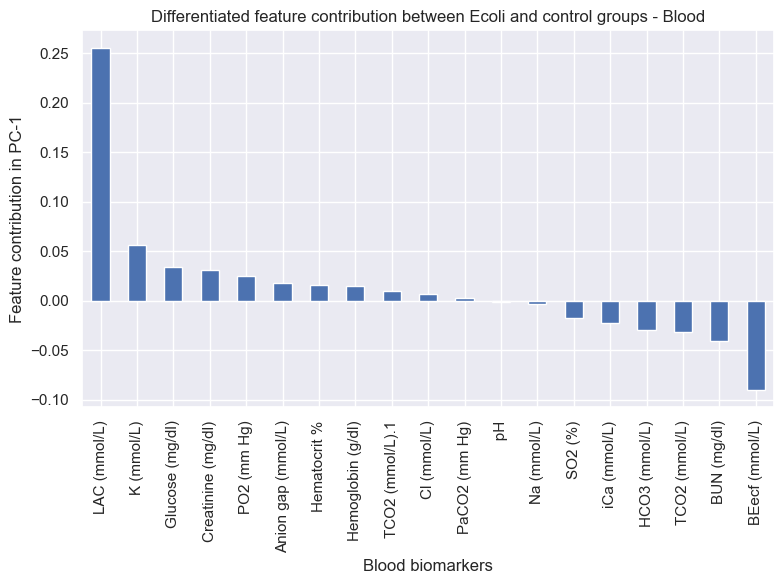

In [62]:
# Analyze Blood data
result_blood = pd.merge(calculate_pc_sum('EcoliPigs/*.xlsx', 'Blood'), calculate_pc_sum('ControlPigs/*.xlsx', 'Blood'), on='Features', suffixes=('_E', '_C'))
result_blood['difference'] = (result_blood['sum_PC1_E'] / 24 - result_blood['sum_PC1_C'] / 12)
result_blood.sort_values(by='difference', ascending=False, inplace=True)
plot_feature_contribution(result_blood, 'Blood')

Average explained variance ratio by PC1: 0.5819446883949673
Average explained variance ratio by PC1: 0.706414349607975


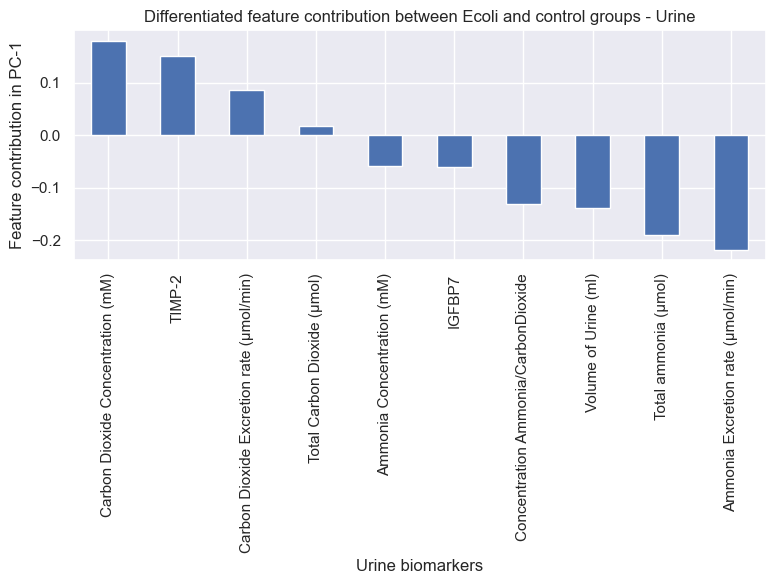

In [64]:
# Analyze Urine Output data
result_NB = pd.merge(calculate_pc_sum('EcoliPigs_NB/*.xlsx', 'Urine Output'), calculate_pc_sum('ControlPigs_NB/*.xlsx', 'Urine Output'), on='Features', suffixes=('_E', '_C'))
result_NB['difference'] = (result_NB['sum_PC1_E'] / 24 - result_NB['sum_PC1_C'] / 12)
result_NB.sort_values(by='difference', ascending=False, inplace=True)
plot_feature_contribution(result_NB, 'Urine')

In [70]:
def load_urine(file_path):
    data = pd.read_excel(file_path, sheet_name='Urine Output', header=0, usecols='E, G, k')
    data.dropna(how='all', axis=1, inplace=True)
    df = data.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    df.bfill(inplace=True)
    df.ffill(inplace=True)
    return df

def perform_urine_pca(file_path):
    df = load_urine(file_path)

    # Drop columns with NaN values before normalization
    df.dropna(axis=1, inplace=True)

    X = df.values.T
    X_norm = Normalizer().fit_transform(X)

    pca = PCA(n_components=2)
    pca.fit_transform(X_norm.T)
    ratio = pca.explained_variance_ratio_

    df_norm = pd.DataFrame(pca.components_.T, index=df.columns, columns=['PC-1', 'PC-2'])
    df_norm.sort_values(by='PC-1', ascending=False, inplace=True)
    df_norm.reset_index(inplace=True, names='Features')

    return ratio, df_norm

def calculate_urine_pc_sum(file_path):
    files = glob.glob(file_path)
    pc1_sum = defaultdict(float)

    for f in files:
        try:
            data = perform_urine_pca(f)
            features = data[1]['Features'].tolist()

            for feature, pc1 in zip(features, data[1]['PC-1']):
                pc1_sum[feature] += pc1

        except Exception as e:
            print(f'Error processing file {f}: {str(e)}')

    result_df = pd.DataFrame(list(pc1_sum.items()), columns=['Features', 'sum_PC1'])
    result_df.sort_values(by='sum_PC1', ascending=False, inplace=True)

    ratio_ave = np.mean(data[0][0])
    print(f'Average explained variance ratio by PC1: {ratio_ave}')

    return result_df

def plot_urine_feature_contribution(result):
    """
    Plot the differentiated feature contribution between groups.
    """   
    result.plot.bar(x='Features', y='difference', figsize=(8, 6))
    ax = plt.gca()
    ax.set_xticklabels(result['Features'], rotation=45, ha='right', fontsize=10)
    ax.set_xlabel('Urine biomarkers')
    ax.set_ylabel('Feature contribution in PC-1')
    ax.set_title('Differentiated feature contribution between Ecoli and control groups - Urine')
    ax.set_xticklabels(result['Features'], rotation=0, ha='center', fontsize=10)
    ax.legend().set_visible(False)
    plt.tight_layout()
    plt.savefig('feature_contribution_urine.png', dpi=300)
    plt.show()

Average explained variance ratio by PC1: 0.7603450777301667
Average explained variance ratio by PC1: 0.6272846131788719


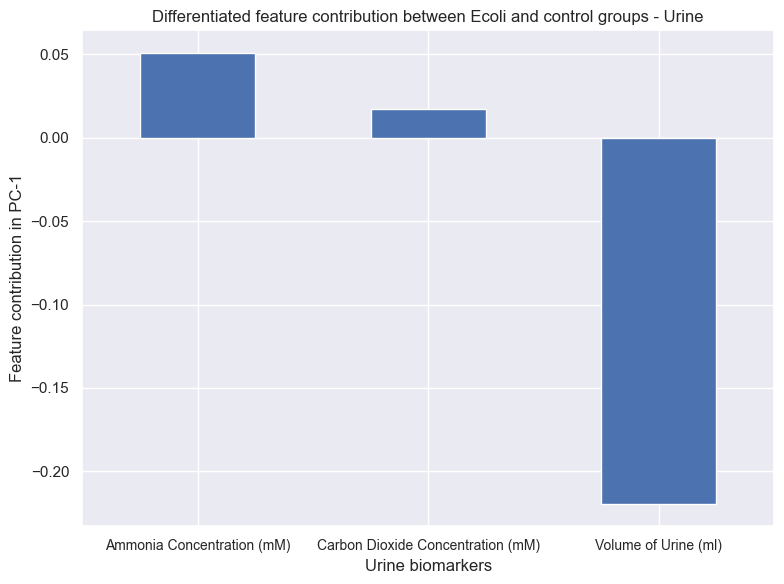

In [71]:
# Analyze Urine Output data with independent variables
result_selected = pd.merge(calculate_urine_pc_sum('EcoliPigs_NB/*.xlsx'), calculate_urine_pc_sum('ControlPigs_NB/*.xlsx'), on='Features', suffixes=('_E', '_C'))
result_selected['difference'] = (result_selected['sum_PC1_E'] / 24 - result_selected['sum_PC1_C'] / 12)
result_selected.sort_values(by='difference', ascending=False, inplace=True)
plot_urine_feature_contribution(result_selected)

### Q2: trend analysis and aggregation result of selected biomarkers

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib import cm
from matplotlib.lines import Line2D

In [2]:
# Function to load and preprocess urine data
def load_and_process_urine_data(group_path):
    # Get all Excel files in the specified directory
    files = glob.glob(group_path + '/*.xlsx')
    df_list = []

    # Loop through each file
    for f in files:
        # Read relevant columns from the 'Urine Output' sheet
        data = pd.read_excel(f, sheet_name='Urine Output', header=0, usecols='D,G,K')
        data = data.apply(lambda col: pd.to_numeric(col, errors='coerce'))
        data['1/CO2'] = 1/data['Carbon Dioxide Concentration (mM)']
        data['NH3_norm'] = data['Ammonia Concentration (mM)']/data['Ammonia Concentration (mM)'].loc[2]
        data['CO2_norm'] = data['Carbon Dioxide Concentration (mM)']/data['Carbon Dioxide Concentration (mM)'].loc[2] 
        data['ratio'] = data['NH3_norm'] / data ['CO2_norm']

        # Extract the numeric ID from the file name
        file_id = int(''.join(filter(str.isdigit, f)))

        # Rename columns using a dictionary comprehension
        new_columns = {
            'Cumilative Time': f'Time_{file_id}',
            'Ammonia Concentration (mM)': f'NH3_{file_id}',
            'Carbon Dioxide Concentration (mM)': f'CO2_{file_id}',
            '1/CO2': f'1/CO2_{file_id}',
            'NH3_norm': f'NH3_norm_{file_id}',
            'CO2_norm': f'CO2_norm_{file_id}',
            'ratio': f'ratio_{file_id}'  
        }

        data.rename(columns=new_columns, inplace=True)
        df_list.append(data)

    # Concatenate DataFrames after the loop
    df = pd.concat(df_list, axis=1)
    
    return df

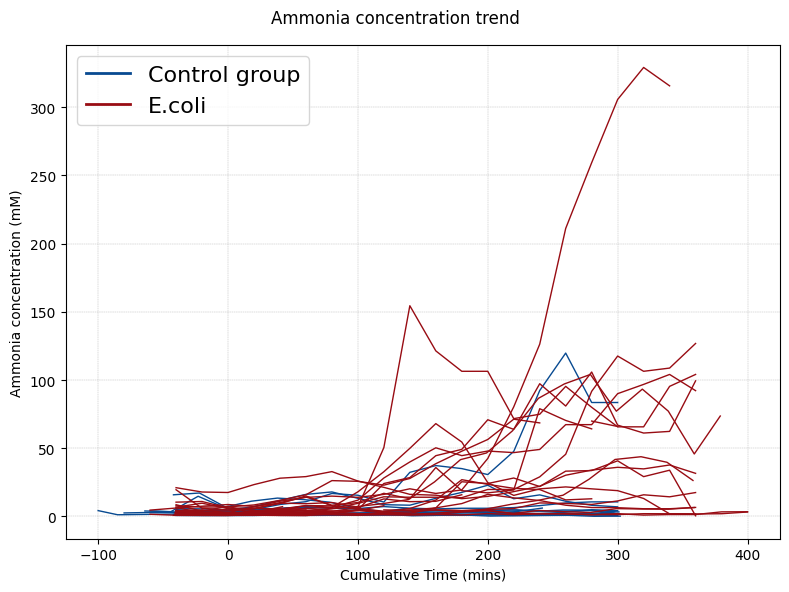

In [14]:
# Load and preprocess urine data for E.coli and control groups
df_U_E = load_and_process_urine_data('EcoliPigs')
df_U_C = load_and_process_urine_data('ControlPigs')

# Plot Ammonia concentration trend
fig, ax=plt.subplots(1, figsize=(8,6), sharex=True)
fig.suptitle('Ammonia concentration trend', y=0.98, fontsize=12)

# Get the colors from the color maps
colors_C = cm.Blues_r(np.linspace(0.1, 1.1, 12))
colors_E = cm.Reds_r(np.linspace(0.1, 1.1, 24))

# Create custom legend handles for each group
legend_handles = [
    Line2D([0], [0], color=colors_C[0], lw=2, label='Control group'),
    Line2D([0], [0], color=colors_E[0], lw=2, label='E.coli')
]

# Plot the data for the control group
for i, j in zip(df_U_C.columns[0::7], df_U_C.columns[1::7]):
    df_U_C.plot(x=i, y=j, ax=ax, legend=None, color=colors_C, linewidth=1, label='Control group')

# Plot the data for the E.coli group
for k, z in zip(df_U_E.columns[0::7], df_U_E.columns[1::7]):
    df_U_E.plot(x=k, y=z, ax=ax, legend=None, color=colors_E, linewidth=1, label='E.coli')

# Set labels and legend
ax.set_xlabel('Cumulative Time (mins)')
ax.set_ylabel('Ammonia concentration (mM)')
ax.grid(linestyle='--', alpha=1, linewidth=0.3)
ax.legend(handles=legend_handles, loc='upper left', fontsize=16)
fig.tight_layout()
fig.savefig('Ammonia concentration trend.png', dpi=300)

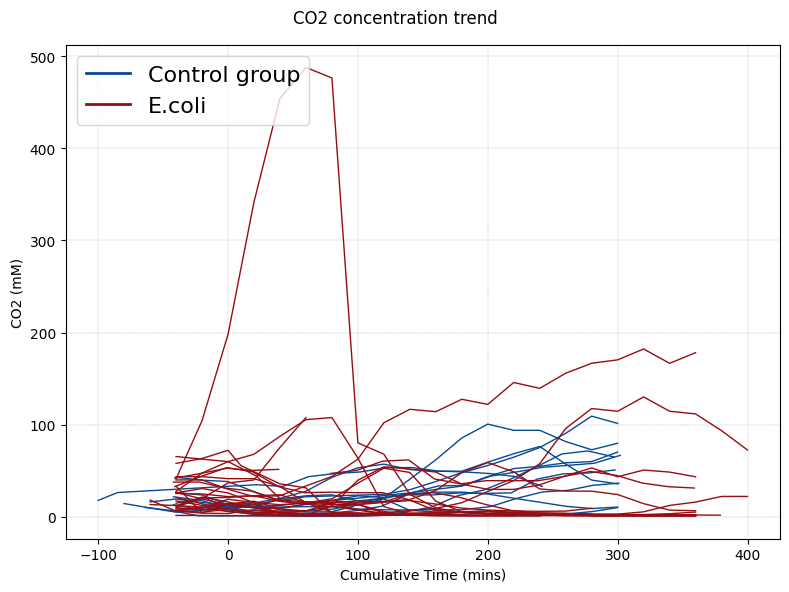

In [13]:
# Load and preprocess urine data for E.coli and control groups
df_U_E = load_and_process_urine_data('EcoliPigs')
df_U_C = load_and_process_urine_data('ControlPigs')

# Plot CO2 concentration trend
fig, ax=plt.subplots(1, figsize=(8,6), sharex=True)
fig.suptitle('CO2 concentration trend', y=0.98, fontsize=12)

# Get the colors from the color maps
colors_C = cm.Blues_r(np.linspace(0.1, 1.1, 12))
colors_E = cm.Reds_r(np.linspace(0.1, 1.1, 24))

# Create custom legend handles for each group
legend_handles = [
    Line2D([0], [0], color=colors_C[0], lw=2, label='Control group'),
    Line2D([0], [0], color=colors_E[0], lw=2, label='E.coli')
]

# Plot the data for the control group
for i, j in zip(df_U_C.columns[0::7], df_U_C.columns[2::7]):
    df_U_C.plot(x=i, y=j, ax=ax, legend=None, color=colors_C, linewidth=1, label='Control group')

# Plot the data for the E.coli group
for k, z in zip(df_U_E.columns[0::7], df_U_E.columns[2::7]):
    df_U_E.plot(x=k, y=z, ax=ax, legend=None, color=colors_E, linewidth=1, label='E.coli')

# Set labels and legend
ax.set_xlabel('Cumulative Time (mins)')
ax.set_ylabel('CO2 (mM)')
ax.grid(linestyle='--', alpha=1, linewidth=0.3)
ax.legend(handles=legend_handles, loc='upper left', fontsize=16)
fig.tight_layout()
fig.savefig('CO2 concentration trend.png', dpi=300)

In [15]:
def df_group(group_path):
    files = glob.glob(group_path + '/*.xlsx')
    df_list = []

    for f in files:
        data = pd.read_excel(f, sheet_name='Urine Output', header=0, usecols='D,G')
        data = data.apply(lambda col: pd.to_numeric(col, errors='coerce'))
        
        # Extract the numeric ID from the file name
        file_id = int(''.join(filter(str.isdigit, f)))

        # Rename columns using a list comprehension
        new_columns = {
            'Cumilative Time': f'Time_{file_id}',
            'Ammonia Concentration (mM)': f'NH3_{file_id}',
        }

        data.rename(columns=new_columns, inplace=True)
        df_list.append(data)

    # Concatenate DataFrames after the loop
    df_group = pd.concat(df_list, axis=1)
    df_group['avg'] = df_group.iloc[:, 1::2].mean(axis=1)
    df_group['std'] = df_group.iloc[:, 1::2].std(axis=1)
    return df_group.iloc[:,[0,-2,-1]]

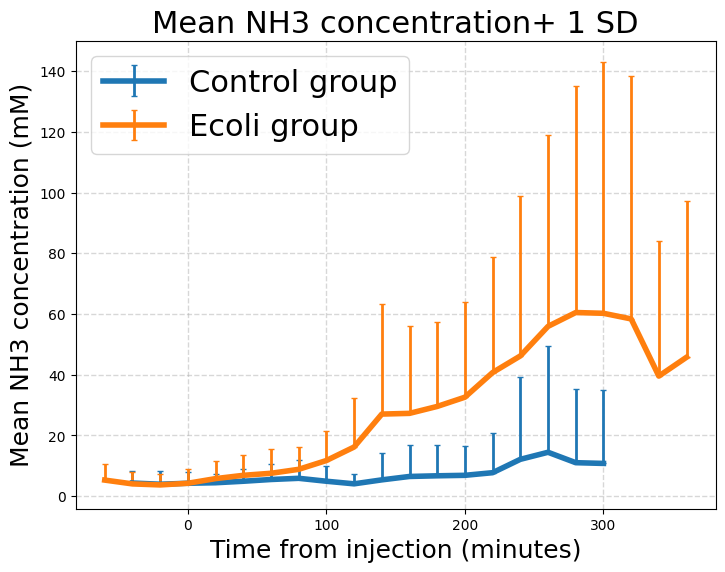

In [16]:
df_c = df_group('ControlPigs')
df_e = df_group('EcoliPigs')

plt.figure(figsize=(8,6))

plt.errorbar(df_c['Time_13'], df_c['avg'], yerr=[0*df_c['std'], df_c['std']], elinewidth=2, lw=4, capsize=2, label='Control group')
plt.errorbar(df_e['Time_26'], df_e['avg'], yerr=[0*df_e['std'], df_e['std']], elinewidth=2, lw=4, capsize=2, label='Ecoli group')

plt.xlabel('Time from injection (minutes)', fontsize=18)
plt.ylabel('Mean NH3 concentration (mM)', fontsize=18)
plt.yticks(fontsize=10)
plt.xticks([0, 100, 200, 300], fontsize=10)
plt.grid(linestyle='--', alpha=0.5, linewidth=1)
plt.title('Mean NH3 concentration+ 1 SD', fontsize=22)
plt.legend(loc='upper left', fontsize=22)
#plt.text(-100, 87, '(b)', fontsize=15)
plt.subplots_adjust(bottom=0.10, left=0.10)

plt.savefig('average ammonia concentration change.png', dpi=150)

### Q3: Receiving Operation Characteristics of selected biomarkers

In [7]:
import numpy as np
from numpy import arange
import glob 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

In [8]:
def df_U(group_path):
    files = glob.glob(group_path + '/*.xlsx')
    df_list = []

    for f in files:
        data = pd.read_excel(f, sheet_name='Urine Output', header=0, usecols='D,G,K,O,P')
        data = data.apply(lambda col: pd.to_numeric(col, errors='coerce'))
        data['1/CO2'] = 1/data['Carbon Dioxide Concentration (mM)']
        data['NH3_norm'] = data['Ammonia Concentration (mM)']/data['Ammonia Concentration (mM)'].loc[2]
        data['CO2_norm'] = data['Carbon Dioxide Concentration (mM)']/data['Carbon Dioxide Concentration (mM)'].loc[2] 
        data['ratio'] = data['NH3_norm'] / data ['CO2_norm'] 

        # Extract the numeric ID from the file name
        file_id = int(''.join(filter(str.isdigit, f)))

        # Rename columns using a list comprehension
        new_columns = {
            'Cumilative Time': f'Time_{file_id}',
            'Ammonia Concentration (mM)': f'NH3_{file_id}',
            'Carbon Dioxide Concentration (mM)': f'CO2_{file_id}',
             'TIMP-2': f'TIMP2_{file_id}',
            'IGFBP7': f'IGFBP7_{file_id}',
            '1/CO2': f'1/CO2_{file_id}',
            'NH3_norm': f'NH3_norm_{file_id}',
            'CO2_norm': f'CO2_norm_{file_id}',
            'ratio': f'ratio_{file_id}'  
        }

        data.rename(columns=new_columns, inplace=True)
        df_list.append(data)

    # Concatenate DataFrames after the loop
    df = pd.concat(df_list, axis=1)
    
    return df

In [9]:
df_U_E = df_U('EcoliPigs')
df_U_C = df_U('ControlPigs')

In [10]:
def df_B(group_path):
    files = glob.glob(group_path + '/*.xlsx')
    df_list = []

    for f in files:
        data = pd.read_excel(f, sheet_name='Blood', header=1, usecols='D,L,U')
        data = data.apply(lambda col: pd.to_numeric(col, errors='coerce'))
        
        # Extract the numeric ID from the file name
        file_id = int(''.join(filter(str.isdigit, f)))

        # Rename columns using a list comprehension
        new_columns = {
            'Cumulative Time': f'Time_{file_id}',
            'LAC (mmol/L)': f'LAC_{file_id}',
            'Creatinine (mg/dl)': f'Cr_{file_id}'
        }

        data.rename(columns=new_columns, inplace=True)
        df_list.append(data)

    # Concatenate DataFrames after the loop
    df = pd.concat(df_list, axis=1)
    
    return df

In [11]:
df_B_E = df_B('EcoliPigs')
df_B_C = df_B('ControlPigs')

In [12]:
# total number of positive P, total number of negative N
path_E='EcoliPigs'
P=len(glob.glob1(path_E, '*.xlsx'))

path_C='ControlPigs'
N=len(glob.glob1(path_C, '*.xlsx'))

def auc(name, range, ncol):
    TPR = [1]
    FPR = [1]
    for thresh in range:
        FN=0
        TP=0
        for i, j in zip(df_U_E.columns[0::9], df_U_E.columns[ncol::9]):
            if df_U_E[i][df_U_E[i].notnull()].iloc[-1]<180:
                TP += 1
            elif any(df_U_E[j][df_U_E[j].notnull()]>=thresh):
                TP += 1
            else:
                FN += 1
        FP=0
        TN=0
        for k in df_U_C.columns[ncol::9]:
            if all(df_U_C[k][df_U_C[k].notnull()]<thresh):
                TN += 1
            else:
                FP += 1
        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN)) 
    TPR.append(0)
    FPR.append(0)
    auc = -np.trapz(y=TPR, x=FPR, axis=0)
    return auc, TPR, FPR

auc_TIMP, TPR_TIMP, FPR_TIMP = auc('TIMP', np.arange(0, 12000, 100), 3)
auc_IGFBP, TPR_IGFBP, FPR_IGFBP = auc('IGFBP', np.arange(0, 80, 0.5), 4)
auc_NH3, TPR_NH3, FPR_NH3 = auc('NH3', np.arange(0, 350, 2), 1)
auc_CO2, TPR_CO2, FPR_CO2 = auc('CO2', np.arange(0, 1.5, 0.01), 5)
auc_ratio, TPR_ratio, FPR_ratio = auc('ratio', np.arange(0, 300, 2), 8)

print(f'AUC for TIMP: {auc_TIMP}')

AUC for TIMP: 0.53125


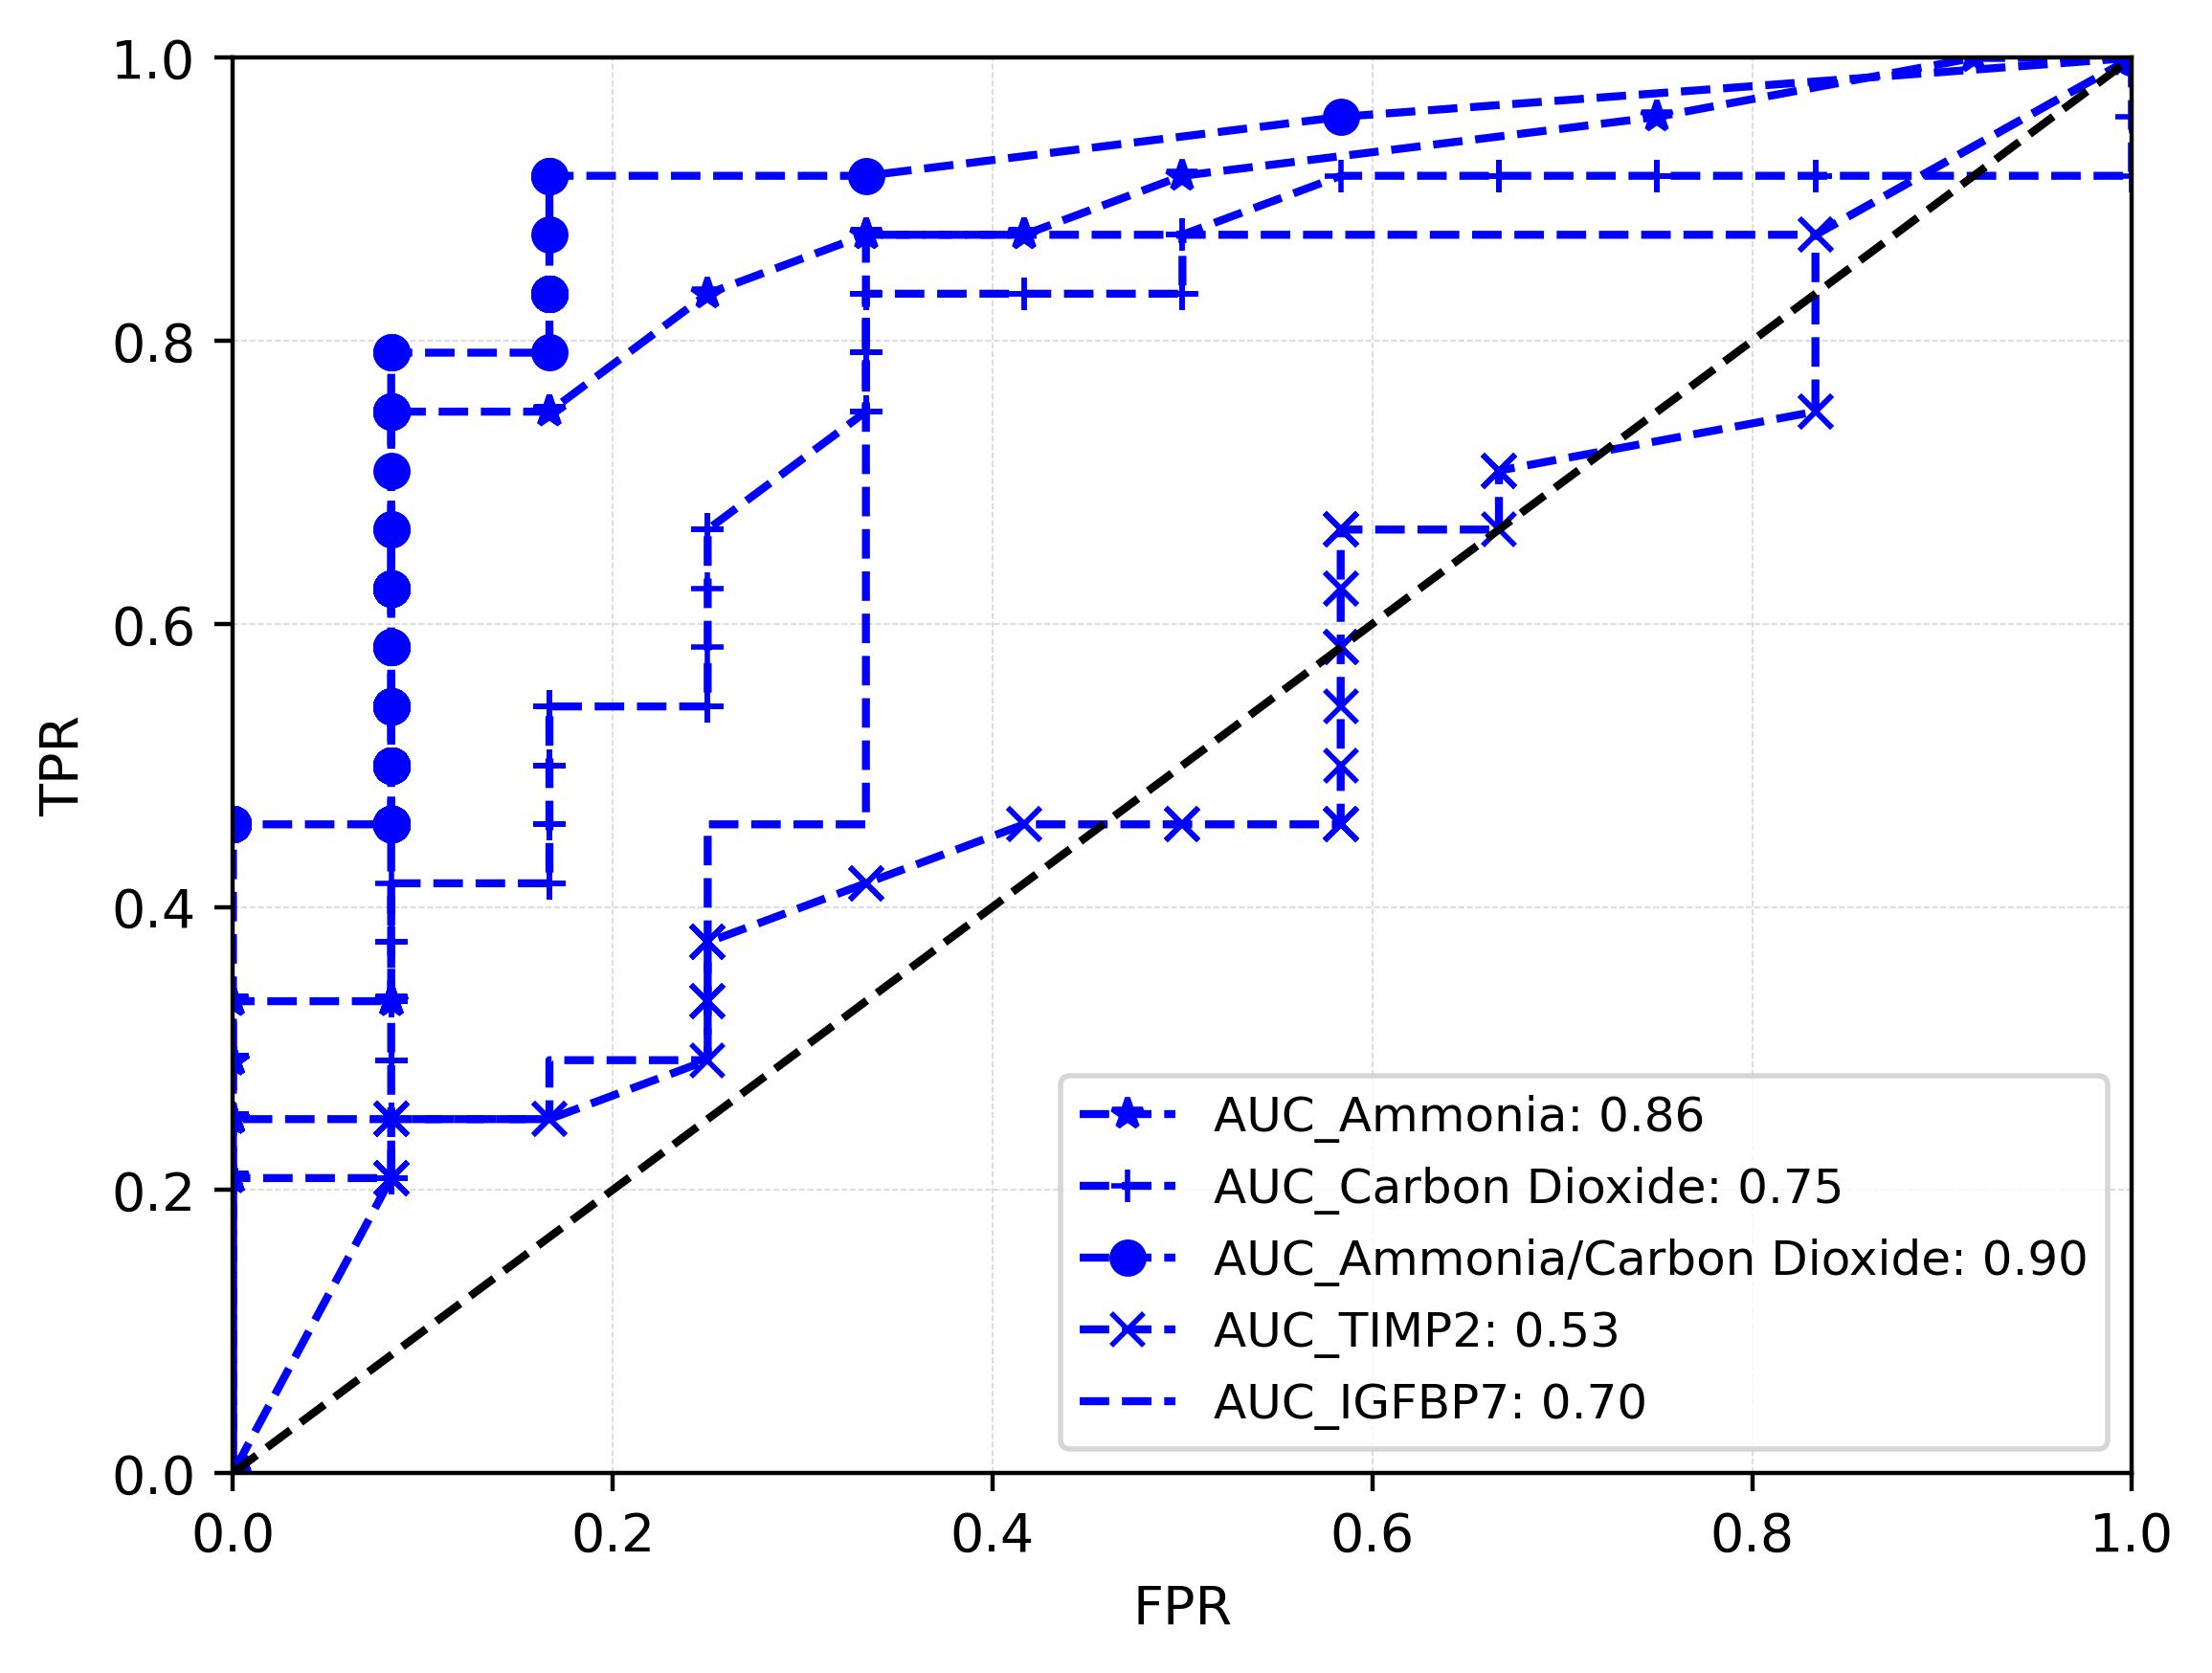

In [13]:
def auc(name, range, ncol):
    TPR = [1]
    FPR = [1]
    for thresh in range:
        FN=0
        TP=0
        for i, j in zip(df_B_E.columns[0::3], df_B_E.columns[ncol::3]):
            if df_B_E[i][df_B_E[i].notnull()].iloc[-1]<180:
                TP += 1
            elif any(df_B_E[j][df_B_E[j].notnull()]>=thresh):
                TP += 1
            else:
                FN += 1
        FP=0
        TN=0
        for k in df_B_C.columns[ncol::3]:
            if all(df_B_C[k][df_B_C[k].notnull()]<thresh):
                TN += 1
            else:
                FP += 1
        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN)) 
    TPR.append(0)
    FPR.append(0)
    auc = -np.trapz(y=TPR, x=FPR, axis=0)
    return auc, TPR, FPR

auc_LAC, TPR_LAC, FPR_LAC = auc('LAC', np.arange(1, 9, 0.1), 1)
auc_Cr, TPR_Cr, FPR_Cr = auc('Cr', np.arange(0.8, 2.5, 0.05), 2)

x=np.arange(0, 1.01, 0.1)
y=np.arange(0, 1.01, 0.1)

plt.figure()
plt.plot(FPR_NH3, TPR_NH3, '*--', color='blue', label=f'AUC_Ammonia: {auc_NH3:.2f}')
plt.plot(FPR_CO2, TPR_CO2, '+--', color='blue', label=f'AUC_Carbon Dioxide: {auc_CO2:.2f}')
plt.plot(FPR_ratio, TPR_ratio, 'o--', color='blue', label=f'AUC_Ammonia/Carbon Dioxide: {auc_ratio:.2f}')
plt.plot(FPR_TIMP, TPR_TIMP, 'x--',  color='blue', label=f'AUC_TIMP2: {auc_TIMP:.2f}')
plt.plot(FPR_IGFBP, TPR_IGFBP, '--', color='blue', label=f'AUC_IGFBP7: {auc_IGFBP:.2f}')

plt.plot(x, y, '--', color='black')

plt.xlabel('FPR', fontsize=10)
plt.ylabel('TPR', fontsize=10)
#plt.title('ROC_urinary biomarkers', fontsize=14)
plt.legend(loc='lower right', fontsize=9)
plt.grid(linestyle='--', alpha=0.5, linewidth=0.3)
plt.ylim([0, 1])
plt.xlim([0, 1])
#plt.text(-0.13, 1, '(a)', fontsize=15)

plt.savefig('ROC_urine biomarkers.png', dpi=300)

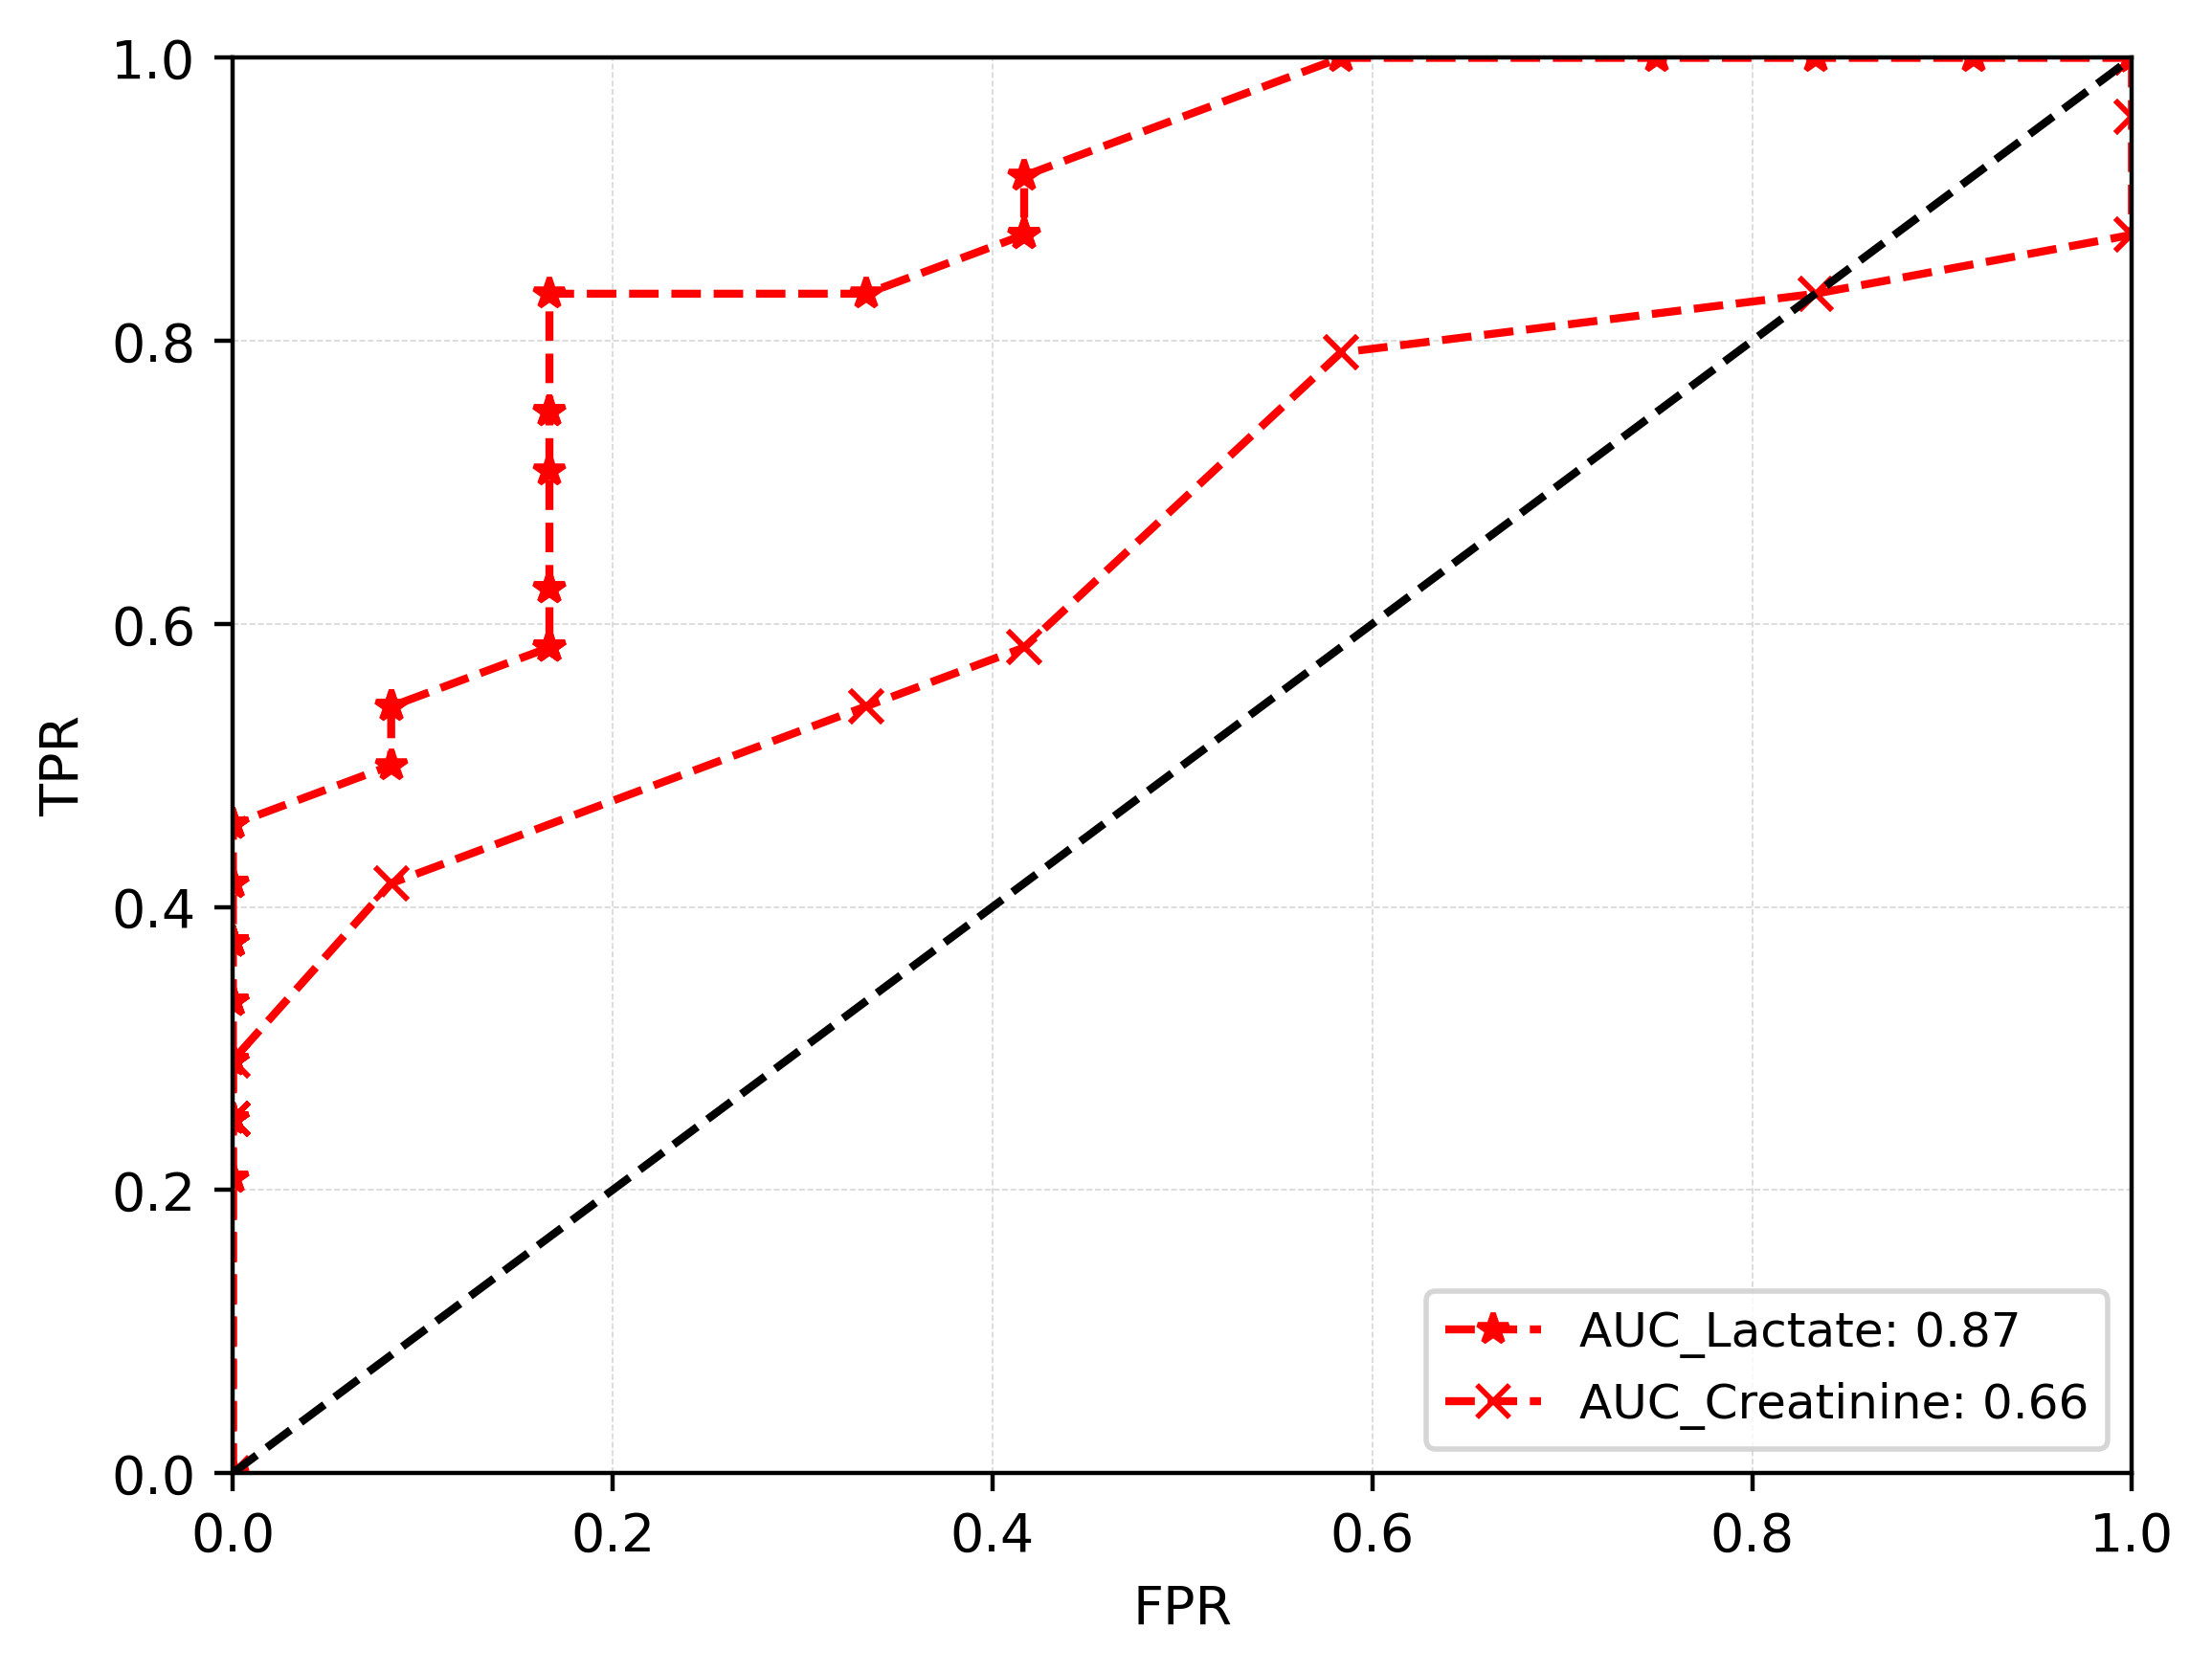

In [14]:
x=np.arange(0, 1.01, 0.1)
y=np.arange(0, 1.01, 0.1)

plt.figure()

plt.plot(FPR_LAC, TPR_LAC, '*--', color='red', label=f'AUC_Lactate: {auc_LAC:.2f}')
plt.plot(FPR_Cr, TPR_Cr, 'x--', color='red', label=f'AUC_Creatinine: {auc_Cr:.2f}')

plt.plot(x, y, '--', color='black')

plt.xlabel('FPR', fontsize=10)
plt.ylabel('TPR', fontsize=10)
#plt.title('ROC_blood biomarkers', fontsize=14)
plt.legend(loc='lower right', fontsize=9)
plt.grid(linestyle='--', alpha=0.5, linewidth=0.3)
plt.ylim([0, 1])
plt.xlim([0, 1])
#plt.text(-0.13, 1, '(b)', fontsize=15)

plt.savefig('ROC_blood biomarkers.png', dpi=300)